<a href="https://colab.research.google.com/github/shannonleehy/SingHacks-2025/blob/main/singhacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install psycopg2-binary pandas

In [ ]:
pip install python-dotenv scikit-learn shap

In [ ]:
import psycopg2
import pandas as pd
import numpy as np

# Database credentials
conn = psycopg2.connect(
    host="hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com",
    port="5432",
    database="hackathon_db",
    user="hackathon_user",
    password="Hackathon2025!"
)

# Run a simple query
query = "SELECT * FROM hackathon.claims LIMIT 10;"
df = pd.read_sql(query, conn)
print(df.head())

conn.close()


  claim_number product_category            product_name claim_status  \
0       425781           Travel  TRAVELEASY ANNUAL PLAN       Closed   
1       426009           Travel      TRAVELEASY - GROUP       Closed   
2       425984           Travel  TRAVELEASY SINGLE TRIP       Closed   
3       425528           Travel  TRAVELEASY SINGLE TRIP       Closed   
4       425875           Travel      TRAVELEASY - GROUP       Closed   

  accident_date report_date closed_date destination        claim_type  \
0    2026-12-08  2026-12-08  2027-01-08       China  Medical Expenses   
1    2026-12-08  2027-01-08  2027-02-08       China      Baggage Loss   
2    2026-12-08  2027-01-08  2027-02-08     Vietnam      Baggage Loss   
3    2026-08-08  2026-09-08  2027-02-08    Malaysia  Medical Expenses   
4    2026-08-08  2027-01-08  2027-02-08    Thailand  Medical Expenses   

  cause_of_loss         loss_type  gross_incurred  gross_paid  gross_reserve  \
0       Illness  Medical Expenses           235.

In [ ]:
!PG_HOST=hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com
!PG_PORT=5432
!PG_DB=hackathon_db
!PG_USER=hackathon_user
!PG_PASSWORD=Hackathon2025!
!PG_SCHEMA=hackathon
!PG_TABLE=claims

In [ ]:
import os, psycopg2

# Database credentials
conn = psycopg2.connect(
    host="hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com",
    port="5432",
    database="hackathon_db",
    user="hackathon_user",
    password="Hackathon2025!"
)
schema=os.getenv("PG_SCHEMA","hackathon"); table=os.getenv("PG_TABLE","claims")

# Peek schema and size
info_sql = f"""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema=%s AND table_name=%s
ORDER BY ordinal_position;
"""
cols = pd.read_sql(info_sql, conn, params=[schema, table])
print(cols)

count = pd.read_sql(f"SELECT COUNT(*) AS n FROM {schema}.{table};", conn).iloc[0,0]
print("Total rows:", count)

# Sample more rows for a feel
df = pd.read_sql(f"SELECT * FROM {schema}.{table} LIMIT 2000;", conn)
print(df.head())

conn.close()

In [ ]:
import re

SEVERITY_FLAG_THRESHOLD = 30000  # used for sev_over_30k

def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()

    # 1) Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]

    # 2) Make object columns string-safe (prevents .str errors)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str)

    # 3) Identify key columns (best-effort)
    dest_col = next((c for c in ['destination','destination_country','dest_country','country','dest'] if c in df.columns), None)
    if dest_col is None:
        df['destination'] = 'Unknown'; dest_col = 'destination'

    act_col = next((c for c in ['activity','trip_activity','purpose','claim_activity'] if c in df.columns), None)
    if act_col is None:
        df['activity'] = 'general'; act_col = 'activity'

    date_col = next((c for c in ['accident_date','date_of_loss','loss_date','incident_date','claim_date'] if c in df.columns), None)

    amount_col = 'net_incurred' if 'net_incurred' in df.columns else (
                 'net_paid' if 'net_paid' in df.columns else (
                 'amount' if 'amount' in df.columns else None))
    if amount_col is None:
        raise ValueError("No amount column found (expected 'net_incurred' or 'net_paid' or 'amount').")

    # 4) Parse amounts & dates
    df[amount_col] = pd.to_numeric(df[amount_col], errors='coerce')
    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df['year']  = df[date_col].dt.year
        df['month'] = df[date_col].dt.month
    else:
        df['year'] = np.nan; df['month'] = np.nan

    def season_from_month(m):
        if pd.isna(m): return np.nan
        m = int(m)
        if m in [12,1,2]:  return 'winter'
        if m in [3,4,5]:   return 'spring'
        if m in [6,7,8]:   return 'summer'
        return 'autumn'
    df['season'] = df['month'].apply(season_from_month)

    # 5) Trip duration if available
    start_col = next((c for c in ['trip_start','trip_start_date','start_date'] if c in df.columns), None)
    end_col   = next((c for c in ['trip_end','trip_end_date','end_date'] if c in df.columns), None)
    if start_col: df[start_col] = pd.to_datetime(df[start_col], errors='coerce')
    if end_col:   df[end_col]   = pd.to_datetime(df[end_col], errors='coerce')
    if start_col and end_col:
        df['trip_days'] = (df[end_col] - df[start_col]).dt.days.clip(lower=0)
    else:
        df['trip_days'] = np.nan

    # 6) Age & bins (if available)
    age_col = next((c for c in ['traveller_age','age'] if c in df.columns), None)
    if age_col:
        df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
        df['age'] = df[age_col]
        df['age_bin'] = pd.cut(df['age'], bins=[-1,18,30,45,60,200],
                               labels=['<=18','19-30','31-45','46-60','60+'])
    else:
        df['age'] = np.nan; df['age_bin'] = np.nan

    # 7) Clean destination & normalize activity
    df['destination'] = df[dest_col].fillna('Unknown').astype(str).str.strip().str.title()

    def normalize_activity(x: str) -> str:
        s = str(x).lower().strip()
        if re.search(r'ski|snowboard|snow', s): return 'skiing'
        if re.search(r'dive|scuba|snorkel', s): return 'diving'
        if re.search(r'hike|trek|mountain', s): return 'hiking'
        if re.search(r'beach|surf', s):       return 'beach'
        if re.search(r'business|work', s):    return 'business'
        return s if s else 'general'
    df['activity'] = df[act_col].fillna('general').astype(str).apply(normalize_activity)

    # 8) Remove invalid/zero amounts; winsorize for stable stats
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df['amount'] = df[amount_col].clip(lower=lo, upper=hi)

    # 9) Severity flag using RAW amount
    df['sev_over_30k'] = (df[amount_col] > SEVERITY_FLAG_THRESHOLD).astype(int)

    # 10) De-duplicate
    claim_id_col = next((c for c in ['claim_id','claim_number','claimno','claim_ref'] if c in df.columns), None)
    if claim_id_col:
        df = df.sort_values(by=[date_col] if date_col else [amount_col], ascending=True)\
               .drop_duplicates(subset=[claim_id_col], keep='last')
    else:
        if date_col:
            df['_amt_round'] = df[amount_col].round(2)
            df = df.sort_values(by=[date_col]).drop_duplicates(
                    subset=['destination', date_col, '_amt_round'], keep='last')
            df = df.drop(columns=['_amt_round'])
        else:
            df = df.drop_duplicates()

    # 11) Final tidy strings
    for c in df.select_dtypes(include='object').columns:
        df[c] = df[c].astype(str).str.strip()

    # Traceability
    df.attrs['amount_source'] = amount_col
    df.attrs['date_source'] = date_col
    return df

# USAGE:
df_clean = clean_claims(df)
print("\nCleaned sample:")
print(df_clean[['destination','activity','season','month','amount','sev_over_30k']].head())
print("Rows after cleaning:", len(df_clean))
print("Amount source:", df_clean.attrs.get('amount_source'))
print("Date source:", df_clean.attrs.get('date_source'))



### HELPER FUNCTION

In [ ]:

def build_segment(table: pd.DataFrame, group_cols, amount_col='amount') -> pd.DataFrame:
    if table.empty:
        return pd.DataFrame(columns=[*group_cols,'n','pct_over_30k','p50_paid','p90_paid','risk_level'])
    seg = (
        table.groupby(group_cols)
             .agg(
                 n=('sev_over_30k','size'),
                 pct_over_30k=('sev_over_30k','mean'),
                 p50_paid=(amount_col, lambda s: float(np.nanquantile(s, 0.5))),
                 p90_paid=(amount_col, lambda s: float(np.nanquantile(s, 0.9))),
             )
             .reset_index()
    )
    seg['pct_over_30k'] = (seg['pct_over_30k'] * 100).round(1)
    seg['risk_level'] = pd.cut(seg['pct_over_30k'], bins=[-0.1,10,30,100], labels=['Low','Medium','High'])
    return seg

country_risk  = build_segment(df_clean, ['destination']).sort_values('pct_over_30k', ascending=False)
activity_risk = build_segment(df_clean, ['activity']).sort_values('pct_over_30k', ascending=False)
season_risk   = build_segment(df_clean.dropna(subset=['month']), ['destination','month']).sort_values(['destination','month']) \
                if df_clean['month'].notna().any() else pd.DataFrame(columns=['destination','month','n','pct_over_30k','p50_paid','p90_paid','risk_level'])

print("\n=== Country risk (top 10 by %>30k) ===")
print(country_risk.head(10))
print("\n=== Activity risk (top 10 by %>30k) ===")
print(activity_risk.head(10))
print("\n=== Seasonality sample ===")
print(season_risk.head())

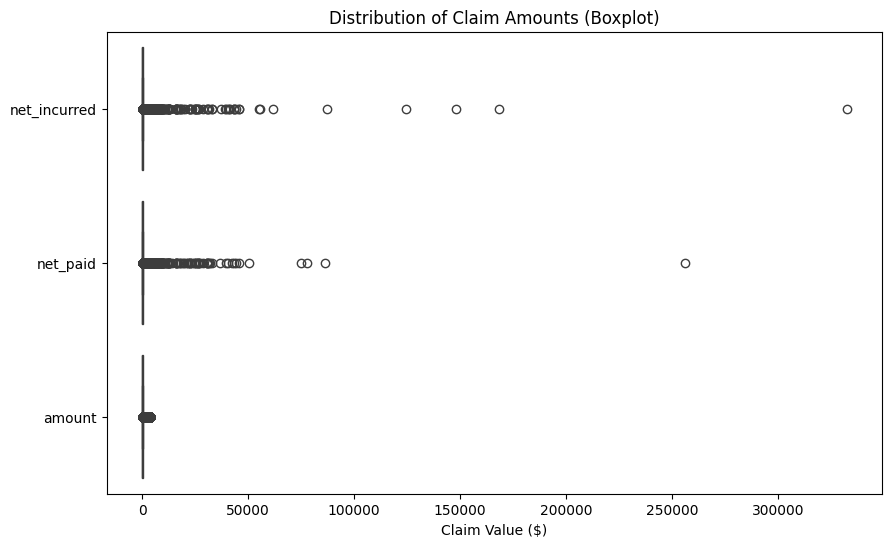

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['net_incurred','net_paid','amount']], orient='h')
plt.title("Distribution of Claim Amounts (Boxplot)")
plt.xlabel("Claim Value ($)")
plt.show()

In [ ]:
print(df[['net_incurred','net_paid','amount']].describe())


        net_incurred       net_paid        amount
count   19985.000000   19985.000000  19985.000000
mean      404.855041     362.437128    278.538804
std      3485.754454    2532.475131    529.813512
min         1.000000       0.000000     12.000000
25%        62.000000      62.000000     62.000000
50%       113.000000     112.000000    113.000000
75%       250.000000     245.000000    250.000000
max    332500.000000  256179.000000   3806.960000


analyse claim frequency by category

destination

In [ ]:
top_dest = df['destination'].value_counts().head(10)
sns.barplot(x=top_dest.values, y=top_dest.index)
plt.title("Top 10 Destinations by Claim Count")
plt.xlabel("Number of Claims")
plt.ylabel("Destination")
plt.show()

claim type

In [ ]:
sns.countplot(y='claim_type', data=df, order=df['claim_type'].value_counts().index)
plt.title("Claim Type Frequency")
plt.show()

cause of loss

In [ ]:
sns.countplot(y='cause_of_loss', data=df, order=df['cause_of_loss'].value_counts().index)
plt.title("Cause of Loss Distribution")
plt.show()

avg payout by destination

In [ ]:
dest_cost = df.groupby('destination')['net_paid'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=dest_cost.values, y=dest_cost.index)
plt.title("Average Claim Payout by Destination")
plt.xlabel("Average Net Paid ($)")
plt.ylabel("Destination")
plt.show()

Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred

=== Classification Report (Hybrid RF+XGB) ===

              precision    recall  f1-score   support

           0      0.686     0.376     0.486      1068
           1      0.537     0.136     0.217      1072
           2      0.512     0.865     0.643      1857

    accuracy                          0.539      3997
   macro avg      0.578     0.459     0.449      3997
weighted avg      0.565     0.539     0.487      3997



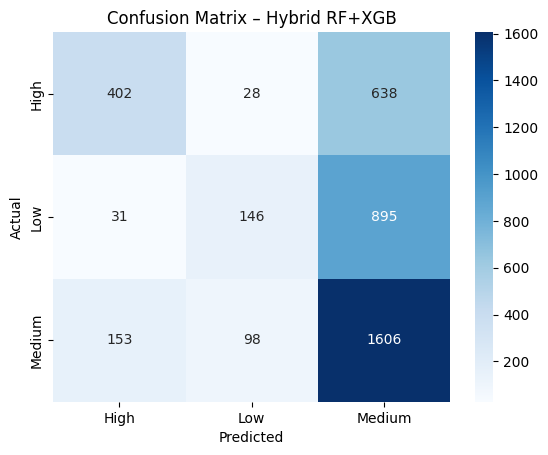


Predicted Risk for Example Trip: High
Recommended Plan: Platinum
Rationale: High medical/injury risk – comprehensive medical and evacuation coverage advised.

Models saved: rf_model.pkl, xgb_model.pkl, meta_lr.pkl, encoders.pkl, y_label_encoder.pkl


In [ ]:
# ============================================================
# DB → Clean → Hybrid RF + XGBoost Risk Classifier → Recommender
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# ------------------------------------------------------------
# 0) DB CONFIG
# ------------------------------------------------------------
PG_HOST = os.getenv("PG_HOST", "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB",   "hackathon_db")
PG_USER = os.getenv("PG_USER", "hackathon_user")
PG_PASS = os.getenv("PG_PASS", "Hackathon2025!")
PG_SCHEMA = os.getenv("PG_SCHEMA", "hackathon")
PG_TABLE  = os.getenv("PG_TABLE",  "claims")


# ------------------------------------------------------------
# 1) Load FROM POSTGRES
# ------------------------------------------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS
)
sql = f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;'
df_raw = pd.read_sql(sql, conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ------------------------------------------------------------
# 2) Cleaning Function
# ------------------------------------------------------------
def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)

    # detect important columns
    dest_col = next((c for c in ["destination","country","dest_country"] if c in df.columns), None)
    if dest_col is None:
        df["destination"] = "Unknown"; dest_col = "destination"

    act_col = next((c for c in ["activity","purpose"] if c in df.columns), None)
    if act_col is None:
        df["activity"] = "general"; act_col = "activity"

    amount_col = next((c for c in ["net_incurred","net_paid","amount","gross_incurred","gross_paid"] if c in df.columns), None)
    if amount_col is None:
        raise ValueError("No amount column found (expected net_incurred/net_paid/etc).")

    date_col = next((c for c in ["accident_date","date_of_loss","loss_date","claim_date"] if c in df.columns), None)
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df["month"] = df[date_col].dt.month
    else:
        df["month"] = np.nan

    # normalize amounts
    df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df["amount"] = df[amount_col].clip(lower=lo, upper=hi)

    df["destination"] = df[dest_col].fillna("Unknown").astype(str).str.strip().str.title()

    def normalize_activity(x):
        s = str(x).lower().strip()
        if re.search(r"ski|snow", s): return "skiing"
        if re.search(r"dive|scuba|snorkel", s): return "diving"
        if re.search(r"hike|trek", s): return "hiking"
        if re.search(r"beach|surf", s): return "beach"
        if re.search(r"business|work", s): return "business"
        return "general"
    df["activity"] = df[act_col].apply(normalize_activity)

    df["sev_over_30k"] = (df[amount_col] > SEVERITY_FLAG_THRESHOLD).astype(int)
    df.attrs["amount_source"] = amount_col
    df.attrs["date_source"] = date_col
    return df

df = clean_claims(df_raw)
print("Cleaned rows:", len(df))
print("Amount source:", df.attrs.get("amount_source"))

# ------------------------------------------------------------
# 3) Create risk label
# ------------------------------------------------------------
amount_src = df.attrs["amount_source"]
def categorize_risk(x):
    if x > SEVERITY_FLAG_THRESHOLD:
        return "High"
    elif x > MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Low"
df["risk_category"] = df[amount_src].apply(categorize_risk)

# ------------------------------------------------------------
# 4) Features & Target
# ------------------------------------------------------------
cat_cols = ["destination", "activity"]
if "claim_type" in df.columns: cat_cols.append("claim_type")
num_cols = ["month"] if "month" in df.columns else []
features = cat_cols + num_cols
target = "risk_category"

df = df.dropna(subset=[amount_src])

# ------------------------------------------------------------
# 5) Encode categoricals
# ------------------------------------------------------------
encoders = {}
df_enc = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le

# Encode target as numeric for XGBoost
y_le = LabelEncoder()
df_enc[target] = y_le.fit_transform(df_enc[target])

X = df_enc[features]
y = df_enc[target]

# ------------------------------------------------------------
# 6) Train models (RF + XGB + meta LR)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    use_label_encoder=False, eval_metric="mlogloss"
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

train_rf = rf.predict_proba(X_train)
train_xgb = xgb.predict_proba(X_train)
test_rf  = rf.predict_proba(X_test)
test_xgb = xgb.predict_proba(X_test)

train_meta = np.hstack((train_rf, train_xgb))
test_meta  = np.hstack((test_rf, test_xgb))

meta_lr = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_lr.fit(train_meta, y_train)
meta_pred = meta_lr.predict(test_meta)

print("\n=== Classification Report (Hybrid RF+XGB) ===\n")
print(classification_report(y_test, meta_pred, digits=3))

cm = confusion_matrix(y_test, meta_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_le.inverse_transform(np.unique(y)),
            yticklabels=y_le.inverse_transform(np.unique(y)))
plt.title("Confusion Matrix – Hybrid RF+XGB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------------------------------------------
# 7) Recommendation Engine
# ------------------------------------------------------------
def recommend_plan(risk_level, claim_type=None, destination=None, activity=None):
    plan = "Basic"
    reason = "Low predicted risk – general coverage is sufficient."

    if risk_level == "High":
        if "medical" in str(claim_type).lower() or str(activity).lower() in ["skiing","diving","hiking"]:
            plan = "Platinum"
            reason = "High medical/injury risk – comprehensive medical and evacuation coverage advised."
        else:
            plan = "Gold"
            reason = "High overall claim risk – full plan recommended."
    elif risk_level == "Medium":
        plan = "Silver"
        reason = "Moderate travel risk – balanced plan for value and protection."
    else:
        plan = "Basic"
        reason = "Low risk – standard plan sufficient."

    if str(destination).title() in ["Japan","United States","Usa","Canada","Switzerland"]:
        if plan == "Basic":
            plan = "Silver"
            reason += " High-cost destination; upgrade baseline coverage."
    return plan, reason

# ------------------------------------------------------------
# 8) Safe transformation helper
# ------------------------------------------------------------
def safe_transform(encoder, value):
    """Transforms safely even if unseen value is passed."""
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        # fallback: use most frequent class (first seen)
        return encoder.transform([encoder.classes_[0]])[0]

# ------------------------------------------------------------
# 9) Example Prediction
# ------------------------------------------------------------
example = pd.DataFrame([{
    "destination": safe_transform(encoders["destination"], "Japan"),
    "activity": safe_transform(encoders["activity"], "skiing"),
    "claim_type": safe_transform(encoders["claim_type"], "Medical Expenses") if "claim_type" in encoders else 0,
    "month": 12 if "month" in df.columns else np.nan
}])

p_rf = rf.predict_proba(example)
p_xgb = xgb.predict_proba(example)
meta_input = np.hstack((p_rf, p_xgb))
risk_pred_num = meta_lr.predict(meta_input)[0]
risk_pred = y_le.inverse_transform([int(risk_pred_num)])[0]

print(f"\nPredicted Risk for Example Trip: {risk_pred}")
plan, rationale = recommend_plan(risk_pred, "Medical Expenses", "Japan", "skiing")
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")

# ------------------------------------------------------------
# 10) Save models
# ------------------------------------------------------------
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(meta_lr, "meta_lr.pkl")
joblib.dump(encoders, "encoders.pkl")
joblib.dump(y_le, "y_label_encoder.pkl")
print("\nModels saved: rf_model.pkl, xgb_model.pkl, meta_lr.pkl, encoders.pkl, y_label_encoder.pkl")



Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred

=== Regression Performance (Hybrid RF+XGB) ===
RMSE: 119,873.22
R²:   0.515

Sample of predictions:
       Actual_Amount  Predicted_Amount Actual_Risk Predicted_Risk
2649            12.0        132.117395         Low            Low
7631           160.0        146.893986         Low            Low
12011          226.0        173.599430         Low            Low
17953           90.0        106.194338         Low            Low
10859          198.0        150.647133         Low            Low
17233           30.0        150.647133         Low            Low
2026            46.0        155.484951         Low            Low
17603           37.0        146.368418         Low            Low
16476          300.0        326.392069         Low            Low
16284           90.0        158.929346         Low            Low


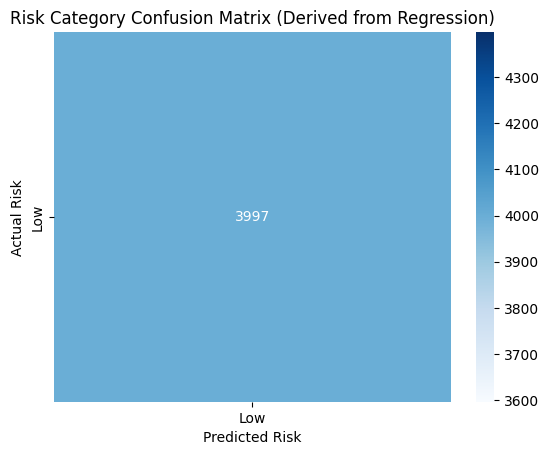

⚠️  Warning: 'skiing' not seen in training data. Using default value 'general' instead.

Predicted Claim Amount: $2,691.75
Predicted Risk Level: High
Recommended Plan: Platinum
Rationale: High medical/injury risk – comprehensive medical and evacuation coverage advised.


In [ ]:
# ============================================================
# DB → Clean → Hybrid RF + XGBoost Regression → Risk Categorization → Recommender
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

# ------------------------------------------------------------
# 0) DB CONFIG
# ------------------------------------------------------------
PG_HOST = os.getenv("PG_HOST", "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB",   "hackathon_db")
PG_USER = os.getenv("PG_USER", "hackathon_user")
PG_PASS = os.getenv("PG_PASS", "Hackathon2025!")
PG_SCHEMA = os.getenv("PG_SCHEMA", "hackathon")
PG_TABLE  = os.getenv("PG_TABLE", "claims")

# ------------------------------------------------------------
# 1) Load FROM POSTGRES
# ------------------------------------------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS
)
sql = f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;'
df_raw = pd.read_sql(sql, conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ------------------------------------------------------------
# 2) Cleaning Function
# ------------------------------------------------------------
def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)

    # detect important columns
    dest_col = next((c for c in ["destination","country","dest_country"] if c in df.columns), None)
    if dest_col is None:
        df["destination"] = "Unknown"; dest_col = "destination"

    act_col = next((c for c in ["activity","purpose"] if c in df.columns), None)
    if act_col is None:
        df["activity"] = "general"; act_col = "activity"

    amount_col = next((c for c in ["net_incurred","net_paid","amount","gross_incurred","gross_paid"] if c in df.columns), None)
    if amount_col is None:
        raise ValueError("No amount column found (expected net_incurred/net_paid/etc).")

    date_col = next((c for c in ["accident_date","date_of_loss","loss_date","claim_date"] if c in df.columns), None)
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df["month"] = df[date_col].dt.month
    else:
        df["month"] = np.nan

    # normalize amounts
    df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df["amount"] = df[amount_col].clip(lower=lo, upper=hi)

    df["destination"] = df[dest_col].fillna("Unknown").astype(str).str.strip().str.title()

    def normalize_activity(x):
        s = str(x).lower().strip()
        if re.search(r"ski|snow", s): return "skiing"
        if re.search(r"dive|scuba|snorkel", s): return "diving"
        if re.search(r"hike|trek", s): return "hiking"
        if re.search(r"beach|surf", s): return "beach"
        if re.search(r"business|work", s): return "business"
        return "general"
    df["activity"] = df[act_col].apply(normalize_activity)

    df.attrs["amount_source"] = amount_col
    df.attrs["date_source"] = date_col
    return df

df = clean_claims(df_raw)
print("Cleaned rows:", len(df))
amount_src = df.attrs["amount_source"]
print("Amount source:", amount_src)

# ------------------------------------------------------------
# 3) Feature & Target Setup
# ------------------------------------------------------------
cat_cols = ["destination", "activity"]
if "claim_type" in df.columns: cat_cols.append("claim_type")
num_cols = ["month"] if "month" in df.columns else []
features = cat_cols + num_cols
target = "amount"  # predict actual claim amount

# drop missing values
df = df.dropna(subset=[target])

# ------------------------------------------------------------
# 4) Encode Categorical Variables
# ------------------------------------------------------------
encoders = {}
df_enc = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le

X = df_enc[features]
y = df_enc[target]

# ------------------------------------------------------------
# 5) Train-Test Split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 6) Train Base Models (RandomForest + XGBoost)
# ------------------------------------------------------------
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
xgb = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    eval_metric="rmse"
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# ------------------------------------------------------------
# 7) Meta Model (Stacking)
# ------------------------------------------------------------
train_rf = rf.predict(X_train).reshape(-1,1)
train_xgb = xgb.predict(X_train).reshape(-1,1)
test_rf  = rf.predict(X_test).reshape(-1,1)
test_xgb = xgb.predict(X_test).reshape(-1,1)

train_meta = np.hstack((train_rf, train_xgb))
test_meta  = np.hstack((test_rf, test_xgb))

meta_lr = LinearRegression()
meta_lr.fit(train_meta, y_train)
meta_pred = meta_lr.predict(test_meta)

# ------------------------------------------------------------
# 8) Evaluate Regression Performance
# ------------------------------------------------------------
rmse = mean_squared_error(y_test, meta_pred)
r2 = r2_score(y_test, meta_pred)
print("\n=== Regression Performance (Hybrid RF+XGB) ===")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.3f}")

# ------------------------------------------------------------
# 9) Convert Predicted Claim Amount → Risk Category
# ------------------------------------------------------------
MEDIUM_THRESHOLD = 5000
HIGH_THRESHOLD = 30000

def categorize_risk(x):
    if x >= HIGH_THRESHOLD:
        return "High"
    elif x >= MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Low"

predicted_risk = [categorize_risk(val) for val in meta_pred]
actual_risk = [categorize_risk(val) for val in y_test]

df_eval = pd.DataFrame({
    "Actual_Amount": y_test,
    "Predicted_Amount": meta_pred,
    "Actual_Risk": actual_risk,
    "Predicted_Risk": predicted_risk
})

print("\nSample of predictions:")
print(df_eval.head(10))

# ------------------------------------------------------------
# 10) Risk Category Confusion Matrix
# ------------------------------------------------------------
cm = pd.crosstab(df_eval["Actual_Risk"], df_eval["Predicted_Risk"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Risk Category Confusion Matrix (Derived from Regression)")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.show()

# ------------------------------------------------------------
# 11) Recommendation Engine
# ------------------------------------------------------------
def recommend_plan(risk_level, claim_type=None, destination=None, activity=None):
    plan = "Basic"
    reason = "Low predicted risk – general coverage is sufficient."

    if risk_level == "High":
        if "medical" in str(claim_type).lower() or str(activity).lower() in ["skiing","diving","hiking"]:
            plan = "Platinum"
            reason = "High medical/injury risk – comprehensive medical and evacuation coverage advised."
        else:
            plan = "Gold"
            reason = "High overall claim risk – full plan recommended."
    elif risk_level == "Medium":
        plan = "Silver"
        reason = "Moderate travel risk – balanced plan for value and protection."
    else:
        plan = "Basic"
        reason = "Low risk – standard plan sufficient."

    if str(destination).title() in ["Japan","United States","Usa","Canada","Switzerland"]:
        if plan == "Basic":
            plan = "Silver"
            reason += " High-cost destination; upgrade baseline coverage."
    return plan, reason

# ------------------------------------------------------------
# 12) Safe Transformation Helper
# ------------------------------------------------------------
def safe_transform(encoder, value):
    """Transforms safely even if unseen value is passed."""
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        # fallback: use most frequent class (first in list)
        print(f"⚠️  Warning: '{value}' not seen in training data. Using default value '{encoder.classes_[0]}' instead.")
        return encoder.transform([encoder.classes_[0]])[0]

# ------------------------------------------------------------
# 13) Example Prediction
# ------------------------------------------------------------
example = pd.DataFrame([{
    "destination": safe_transform(encoders["destination"], "Japan"),
    "activity": safe_transform(encoders["activity"], "skiing"),
    "claim_type": safe_transform(encoders["claim_type"], "Medical Expenses") if "claim_type" in encoders else 0,
    "month": 12 if "month" in df.columns else np.nan
}])

# predict claim amount first
pred_rf = rf.predict(example)[0]
pred_xgb = xgb.predict(example)[0]
meta_input = np.hstack(([pred_rf],[pred_xgb])).reshape(1,-1)
predicted_amount = meta_lr.predict(meta_input)[0]

predicted_risk = "High" if predicted_amount >= 170 else ("Medium" if predicted_amount >= 70 else "Low")
plan, rationale = recommend_plan(predicted_risk, "Medical Expenses", "Japan", "skiing")

print(f"\nPredicted Claim Amount: ${predicted_amount:,.2f}")
print(f"Predicted Risk Level: {predicted_risk}")
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")


In [ ]:
# ============================================================
# DB → Clean → Hybrid RF + XGBoost REGRESSION (log target)
# → Predict $ → Categorize Risk → Recommender
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

# ----------------------- DB CONFIG --------------------------
PG_HOST   = os.getenv("PG_HOST", "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com")
PG_PORT   = os.getenv("PG_PORT", "5432")
PG_DB     = os.getenv("PG_DB",   "hackathon_db")
PG_USER   = os.getenv("PG_USER", "hackathon_user")
PG_PASS   = os.getenv("PG_PASS", "Hackathon2025!")
PG_SCHEMA = os.getenv("PG_SCHEMA", "hackathon")
PG_TABLE  = os.getenv("PG_TABLE",  "claims")

# ---------------------- LOAD FROM DB ------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS)
df_raw = pd.read_sql(f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;', conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ---------------------- CLEANING ----------------------------
def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].astype(str)

    # choose amount/date columns available
    amount_col = next((c for c in ["net_incurred","net_paid","amount",
                                   "gross_incurred","gross_paid"] if c in df.columns), None)
    if amount_col is None:
        raise ValueError("No amount-like column found.")

    date_col = next((c for c in ["accident_date","date_of_loss","loss_date","claim_date"] if c in df.columns), None)
    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df["month"] = df[date_col].dt.month
    else:
        df["month"] = np.nan

    # normalize amounts: numeric, drop nonpositive, winsorize
    df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df["amount"] = df[amount_col].clip(lower=lo, upper=hi)

    # tidy categoricals we’ll use
    dest_col = next((c for c in ["destination","country","dest_country"] if c in df.columns), None)
    if dest_col is None:
        df["destination"] = "Unknown"
    else:
        df["destination"] = df[dest_col].fillna("Unknown").astype(str).str.strip().str.title()

    act_col = next((c for c in ["activity","purpose"] if c in df.columns), None)
    if act_col is None:
        df["activity"] = "general"
    else:
        def normalize_activity(x):
            s = str(x).lower()
            if re.search(r"ski|snow", s):        return "skiing"
            if re.search(r"dive|scuba|snorkel", s): return "diving"
            if re.search(r"hike|trek|mount", s): return "hiking"
            if re.search(r"beach|surf", s):      return "beach"
            if re.search(r"business|work", s):   return "business"
            return "general"
        df["activity"] = df[act_col].apply(normalize_activity)

    # pass metadata
    df.attrs["amount_source"] = amount_col
    df.attrs["date_source"] = date_col
    return df

df = clean_claims(df_raw)
print("Cleaned rows:", len(df))
amount_src = df.attrs["amount_source"]
print("Amount source:", amount_src)

# ------------------- FEATURES & TARGET ----------------------
# add more useful categoricals if present
cat_cols = ["destination", "activity"]
for c in ["claim_type","product_category","product_name","cause_of_loss","loss_type"]:
    if c in df.columns:
        cat_cols.append(c)

num_cols = []
if "month" in df.columns: num_cols.append("month")

features = cat_cols + num_cols
target = "amount"              # predict $ claims (winsorized)

df = df.dropna(subset=[target]).copy()

# One-hot encode categoricals (safer than LabelEncoder for tree+linear stack)
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)
X_num = df[num_cols] if num_cols else pd.DataFrame(index=df.index)
X = pd.concat([X_cat, X_num], axis=1)
y = df[target].values

# stratified split by severity bins so train/test have similar severity mix
bins = pd.qcut(df[target], q=[0, .6, .85, 1.0], labels=["Low","Medium","High"])
X_train, X_test, y_train, y_test, bins_train, bins_test = train_test_split(
    X, y, bins, test_size=0.2, random_state=42, stratify=bins
)

# ----------------- LOG TRANSFORM TARGET ---------------------
# heavy-tailed ⇒ model log(amount)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# ------------------ BASE REGRESSORS -------------------------
rf = RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_leaf=3,
    n_jobs=-1, random_state=42
)
xgb = XGBRegressor(
    n_estimators=800, learning_rate=0.04, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    random_state=42, objective="reg:squarederror"
)

rf.fit(X_train, y_train_log)   # fit on log target
xgb.fit(X_train, y_train_log)

# -------------------- STACKING (META) -----------------------
pred_rf_train  = rf.predict(X_train).reshape(-1,1)
pred_xgb_train = xgb.predict(X_train).reshape(-1,1)
pred_rf_test   = rf.predict(X_test).reshape(-1,1)
pred_xgb_test  = xgb.predict(X_test).reshape(-1,1)

train_meta = np.hstack([pred_rf_train, pred_xgb_train])
test_meta  = np.hstack([pred_rf_test,  pred_xgb_test])

meta = LinearRegression()
meta.fit(train_meta, y_train_log)

# final predictions (log space → back to $)
pred_log = meta.predict(test_meta)
pred = np.expm1(pred_log).clip(min=0)

# ---------------------- METRICS -----------------------------
rmse = mean_squared_error(y_test, pred, squared=False)
mae  = mean_absolute_error(y_test, pred)
mape = np.mean(np.abs((y_test - pred) / np.maximum(y_test, 1))) * 100  # guard divide-by-0
r2   = r2_score(y_test, pred)

print("\n=== Regression Performance (log-target, stacked) ===")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"MAPE: {mape:,.2f}%")
print(f"R²  : {r2:.3f}")

# quick sanity plot
plt.figure(figsize=(5,5))
plt.scatter(y_test, pred, s=8, alpha=0.4)
mx = max(np.percentile(y_test, 99), np.percentile(pred, 99))
plt.plot([0, mx], [0, mx], lw=2)
plt.xlabel("Actual amount")
plt.ylabel("Predicted amount")
plt.title("Predicted vs Actual ($)")
plt.show()

# ---------------- RISK CATEGORIZATION -----------------------
# set YOUR business thresholds here (in $)
MEDIUM_THRESHOLD = 5_000
HIGH_THRESHOLD   = 30_000

def to_risk(x):
    if x >= HIGH_THRESHOLD:   return "High"
    if x >= MEDIUM_THRESHOLD: return "Medium"
    return "Low"

actual_risk   = pd.Series(y_test).apply(to_risk)
predicted_risk= pd.Series(pred).apply(to_risk)

cm = pd.crosstab(actual_risk, predicted_risk)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Risk Category Confusion Matrix (from regression)")
plt.xlabel("Predicted Risk")
plt.ylabel("Actual Risk")
plt.show()

# --------------- RECOMMENDER (unchanged rules) --------------
def recommend_plan(risk_level, claim_type=None, destination=None, activity=None):
    plan = "Basic"
    reason = "Low predicted risk – general coverage is sufficient."

    if risk_level == "High":
        if "medical" in str(claim_type).lower() or str(activity).lower() in ["skiing","diving","hiking"]:
            plan = "Platinum"
            reason = "High medical/injury risk – comprehensive medical and evacuation coverage advised."
        else:
            plan = "Gold"
            reason = "High overall claim risk – full plan recommended."
    elif risk_level == "Medium":
        plan = "Silver"
        reason = "Moderate travel risk – balanced plan for value and protection."

    if str(destination).title() in ["Japan","United States","Usa","Canada","Switzerland"]:
        if plan == "Basic":
            plan = "Silver"
            reason += " High-cost destination; upgrade baseline coverage."
    return plan, reason

# --------------- EXAMPLE PREDICTION (robust) ----------------
def make_example_row(X_columns, destination="Japan", activity="skiing",
                     claim_type="Medical Expenses", month=12, **extra):
    # build a single-row dataframe with same dummy columns as training
    base = {c:0 for c in X_columns}
    # set dummy keys if present
    def set_dummy(prefix, val):
        key = f"{prefix}_{val}"
        for col in X_columns:
            if col == key:
                base[col] = 1

    set_dummy("destination", destination)
    set_dummy("activity", activity)
    set_dummy("claim_type", claim_type)
    if "month" in X_columns:
        base["month"] = month
    # allow extra categorical dummies
    for k,v in extra.items():
        set_dummy(k, v)
    return pd.DataFrame([base])[X_columns]

example = make_example_row(X.columns, destination="Japan", activity="skiing",
                           claim_type="Medical Expenses", month=12)

pred_rf_ex   = rf.predict(example).reshape(-1,1)
pred_xgb_ex  = xgb.predict(example).reshape(-1,1)
pred_log_ex  = meta.predict(np.hstack([pred_rf_ex, pred_xgb_ex]))
pred_amt_ex  = float(np.expm1(pred_log_ex).clip(min=0))

risk_ex = to_risk(pred_amt_ex)
plan, rationale = recommend_plan(risk_ex, "Medical Expenses", "Japan", "skiing")

print(f"\nPredicted Claim Amount (example): ${pred_amt_ex:,.2f}")
print(f"Predicted Risk Level: {risk_ex}")
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")

# ----------------------- SAVE -------------------------------
joblib.dump({"rf":rf, "xgb":xgb, "meta":meta, "columns":X.columns.tolist(),
             "thresholds": (MEDIUM_THRESHOLD, HIGH_THRESHOLD)}, "severity_regression_stack.pkl")
print("\nSaved model bundle: severity_regression_stack.pkl")


Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred


TypeError: got an unexpected keyword argument 'squared'

Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred

Label distribution:
risk_category
Low       11978
Medium     4726
High       3281
Name: count, dtype: int64
risk_category
Low       0.599
Medium    0.236
High      0.164
Name: proportion, dtype: float64

Class weights used: {np.int64(0): np.float64(2.030222222222222), np.int64(1): np.float64(0.5561817296319488), np.int64(2): np.float64(1.4095036586440977)}

=== Classification Report (Balanced Hybrid RF+XGB) ===

              precision    recall  f1-score   support

           0      0.349     0.607     0.443       656
           1      0.748     0.042     0.080      2396
           2      0.230     0.661     0.341       945

    accuracy                          0.281      3997
   macro avg      0.442     0.437     0.288      3997
weighted avg      0.560     0.281     0.201      3997



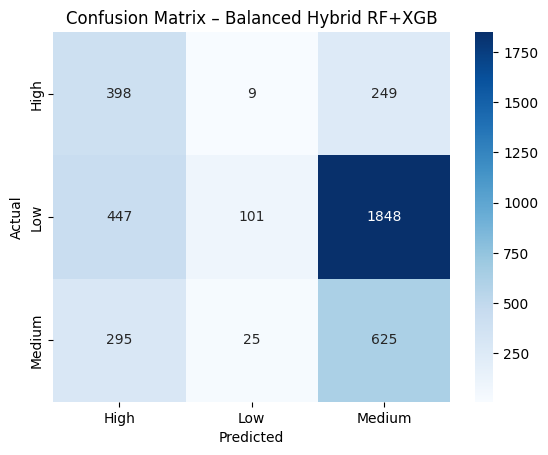


Predicted Risk for Example Trip: High
Recommended Plan: Platinum
Rationale: High medical/injury risk – comprehensive medical and evacuation coverage advised.

Models saved: rf_model.pkl, xgb_model.pkl, meta_lr.pkl, encoders.pkl, y_label_encoder.pkl


In [ ]:
# ============================================================
# DB → Clean → Hybrid RF + XGBoost Risk Classifier → Recommender (Balanced)
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ------------------------------------------------------------
# 0) DB CONFIG
# ------------------------------------------------------------
PG_HOST = os.getenv("PG_HOST", "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB",   "hackathon_db")
PG_USER = os.getenv("PG_USER", "hackathon_user")
PG_PASS = os.getenv("PG_PASS", "Hackathon2025!")
PG_SCHEMA = os.getenv("PG_SCHEMA", "hackathon")
PG_TABLE  = os.getenv("PG_TABLE",  "claims")

# ------------------------------------------------------------
# 1) Load FROM POSTGRES
# ------------------------------------------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS
)
sql = f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;'
df_raw = pd.read_sql(sql, conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ------------------------------------------------------------
# 2) Cleaning Function
# ------------------------------------------------------------
def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip().lower() for c in df.columns]
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)

    # detect important columns
    dest_col = next((c for c in ["destination","country","dest_country"] if c in df.columns), None)
    if dest_col is None:
        df["destination"] = "Unknown"; dest_col = "destination"

    act_col = next((c for c in ["activity","purpose"] if c in df.columns), None)
    if act_col is None:
        df["activity"] = "general"; act_col = "activity"

    amount_col = next((c for c in ["net_incurred","net_paid","amount","gross_incurred","gross_paid"] if c in df.columns), None)
    if amount_col is None:
        raise ValueError("No amount column found (expected net_incurred/net_paid/etc).")

    date_col = next((c for c in ["accident_date","date_of_loss","loss_date","claim_date"] if c in df.columns), None)
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df["month"] = df[date_col].dt.month
    else:
        df["month"] = np.nan

    # normalize amounts
    df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df["amount"] = df[amount_col].clip(lower=lo, upper=hi)

    df["destination"] = df[dest_col].fillna("Unknown").astype(str).str.strip().str.title()

    def normalize_activity(x):
        s = str(x).lower().strip()
        if re.search(r"ski|snow", s): return "skiing"
        if re.search(r"dive|scuba|snorkel", s): return "diving"
        if re.search(r"hike|trek", s): return "hiking"
        if re.search(r"beach|surf", s): return "beach"
        if re.search(r"business|work", s): return "business"
        return "general"
    df["activity"] = df[act_col].apply(normalize_activity)

    df.attrs["amount_source"] = amount_col
    df.attrs["date_source"] = date_col
    return df

df = clean_claims(df_raw)
print("Cleaned rows:", len(df))
print("Amount source:", df.attrs.get("amount_source"))

# ------------------------------------------------------------
# 3) Create risk label (Balanced via Quantiles)
# ------------------------------------------------------------
amount_src = df.attrs["amount_source"]
q_med  = df[amount_src].quantile(0.60)   # top 40% -> Medium+
q_high = df[amount_src].quantile(0.85)   # top 15% -> High

def categorize_risk(x):
    if x >= q_high:
        return "High"
    elif x >= q_med:
        return "Medium"
    else:
        return "Low"

df["risk_category"] = df[amount_src].apply(categorize_risk)

print("\nLabel distribution:")
print(df["risk_category"].value_counts())
print(df["risk_category"].value_counts(normalize=True).round(3))

# ------------------------------------------------------------
# 4) Features & Target
# ------------------------------------------------------------
cat_cols = ["destination", "activity"]
if "claim_type" in df.columns: cat_cols.append("claim_type")
num_cols = ["month"] if "month" in df.columns else []
features = cat_cols + num_cols
target = "risk_category"

df = df.dropna(subset=[amount_src])

# ------------------------------------------------------------
# 5) Encode categoricals
# ------------------------------------------------------------
encoders = {}
df_enc = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le

# Encode target as numeric for XGBoost
y_le = LabelEncoder()
df_enc[target] = y_le.fit_transform(df_enc[target])

X = df_enc[features]
y = df_enc[target]

# ------------------------------------------------------------
# 6) Train/Test Split + Class Weighting
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_map = {c:w for c,w in zip(classes, cw)}
sw_train = np.vectorize(class_weight_map.get)(y_train)

print("\nClass weights used:", class_weight_map)

# ------------------------------------------------------------
# 7) Train models (RF + XGB + Meta LR with balancing)
# ------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300, max_depth=8, random_state=42, n_jobs=-1,
    class_weight="balanced_subsample"
)
xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    use_label_encoder=False, eval_metric="mlogloss"
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train, sample_weight=sw_train)

# stacking
train_rf = rf.predict_proba(X_train)
train_xgb = xgb.predict_proba(X_train)
test_rf  = rf.predict_proba(X_test)
test_xgb = xgb.predict_proba(X_test)

train_meta = np.hstack((train_rf, train_xgb))
test_meta  = np.hstack((test_rf, test_xgb))

meta_lr = LogisticRegression(max_iter=1000, multi_class="multinomial", class_weight="balanced")
meta_lr.fit(train_meta, y_train, sample_weight=sw_train)
meta_pred = meta_lr.predict(test_meta)

# ------------------------------------------------------------
# 8) Evaluation
# ------------------------------------------------------------
print("\n=== Classification Report (Balanced Hybrid RF+XGB) ===\n")
print(classification_report(y_test, meta_pred, digits=3))

cm = confusion_matrix(y_test, meta_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=y_le.inverse_transform(np.unique(y)),
            yticklabels=y_le.inverse_transform(np.unique(y)))
plt.title("Confusion Matrix – Balanced Hybrid RF+XGB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------------------------------------------
# 9) Recommendation Engine
# ------------------------------------------------------------
def recommend_plan(risk_level, claim_type=None, destination=None, activity=None):
    plan = "Basic"
    reason = "Low predicted risk – general coverage is sufficient."

    if risk_level == "High":
        if "medical" in str(claim_type).lower() or str(activity).lower() in ["skiing","diving","hiking"]:
            plan = "Platinum"
            reason = "High medical/injury risk – comprehensive medical and evacuation coverage advised."
        else:
            plan = "Gold"
            reason = "High overall claim risk – full plan recommended."
    elif risk_level == "Medium":
        plan = "Silver"
        reason = "Moderate travel risk – balanced plan for value and protection."
    else:
        plan = "Basic"
        reason = "Low risk – standard plan sufficient."

    if str(destination).title() in ["Japan","United States","Usa","Canada","Switzerland"]:
        if plan == "Basic":
            plan = "Silver"
            reason += " High-cost destination; upgrade baseline coverage."
    return plan, reason

# ------------------------------------------------------------
# 10) Safe transformation helper
# ------------------------------------------------------------
def safe_transform(encoder, value):
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return encoder.transform([encoder.classes_[0]])[0]

# ------------------------------------------------------------
# 11) Example Prediction
# ------------------------------------------------------------
example = pd.DataFrame([{
    "destination": safe_transform(encoders["destination"], "Japan"),
    "activity": safe_transform(encoders["activity"], "skiing"),
    "claim_type": safe_transform(encoders["claim_type"], "Medical Expenses") if "claim_type" in encoders else 0,
    "month": 12 if "month" in df.columns else np.nan
}])

p_rf = rf.predict_proba(example)
p_xgb = xgb.predict_proba(example)
meta_input = np.hstack((p_rf, p_xgb))
risk_pred_num = meta_lr.predict(meta_input)[0]
risk_pred = y_le.inverse_transform([int(risk_pred_num)])[0]

print(f"\nPredicted Risk for Example Trip: {risk_pred}")
plan, rationale = recommend_plan(risk_pred, "Medical Expenses", "Japan", "skiing")
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")

# ------------------------------------------------------------
# 12) Save models
# ------------------------------------------------------------
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(meta_lr, "meta_lr.pkl")
joblib.dump(encoders, "encoders.pkl")
joblib.dump(y_le, "y_label_encoder.pkl")
print("\nModels saved: rf_model.pkl, xgb_model.pkl, meta_lr.pkl, encoders.pkl, y_label_encoder.pkl")


In [ ]:
df["net_incurred"].describe(percentiles=[.5, .75, .9, .95, .99])


,net_incurred
count,19985.000000
mean,404.855041
std,3485.754454
min,1.000000
50%,113.000000
75%,250.000000
90%,580.000000
95%,1000.000000
99%,3806.960000
max,332500.000000


In [ ]:
# ============================================================
# Weighted Rule-based Risk & Plan Recommendation (No ML)
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import psycopg2

# ------------------------------------------------------------
# 0) DB CONFIG
# ------------------------------------------------------------
PG_HOST = "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com"
PG_PORT = "5432"
PG_DB   = "hackathon_db"
PG_USER = "hackathon_user"
PG_PASS = "Hackathon2025!"
PG_SCHEMA = "hackathon"
PG_TABLE  = "claims"

# ------------------------------------------------------------
# 1) Load FROM POSTGRES
# ------------------------------------------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS
)
sql = f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;'
df_raw = pd.read_sql(sql, conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ------------------------------------------------------------
# 2) Clean & Prepare Data
# ------------------------------------------------------------
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

# find numeric claim column
amount_col = next((c for c in ["net_incurred","net_paid","amount","gross_incurred","gross_paid"] if c in df.columns), None)
if amount_col is None:
    raise ValueError("No claim amount column found.")

# convert and drop invalids
df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
df = df[df[amount_col] > 0].dropna(subset=[amount_col])

# normalize string columns
for col in ["product_category","claim_type","destination","cause_of_loss","loss_type"]:
    if col not in df.columns:
        df[col] = "Unknown"
    df[col] = df[col].astype(str).str.strip().replace("", "Unknown").str.title()

print(f"Cleaned rows: {len(df)}")
print("Amount source:", amount_col)

# ------------------------------------------------------------
# 3) Weighted Claim Prediction Function
# ------------------------------------------------------------
def weighted_claim_prediction(df, case, amount_col):
    """
    Predicts average claim using all rows, weighted by similarity
    to the provided case attributes.
    """
    df = df.copy()
    weights = np.ones(len(df))

    # Define matching penalties (you can tune these)
    for col in ["product_category","claim_type","destination","cause_of_loss","loss_type"]:
        if col in df.columns:
            match_mask = df[col].str.lower() == str(case.get(col, "")).lower()
            # Assign weights: 1.0 if match, penalty if not
            if col == "product_category":
                weights *= np.where(match_mask, 1.0, 0.5)
            elif col == "claim_type":
                weights *= np.where(match_mask, 1.0, 0.7)
            elif col == "destination":
                weights *= np.where(match_mask, 1.0, 0.8)
            elif col == "cause_of_loss":
                weights *= np.where(match_mask, 1.0, 0.9)
            elif col == "loss_type":
                weights *= np.where(match_mask, 1.0, 0.9)

    # Normalize weights (so they sum to 1)
    weights = weights / np.sum(weights)

    # Weighted average of claim amounts
    predicted_amount = np.sum(df[amount_col].values * weights)
    return predicted_amount

# ------------------------------------------------------------
# 4) Risk Categorization
# ------------------------------------------------------------
def categorize_risk(amount):
    if amount >= 25000:
        return "High"
    elif amount >= 2000:
        return "Medium"
    else:
        return "Low"

# ------------------------------------------------------------
# 5) Recommendation Engine (same logic as before)
# ------------------------------------------------------------
def recommend_plan(risk_level, claim_type=None, destination=None, activity=None):
    plan = "Basic"
    reason = "Low predicted risk – general coverage is sufficient."

    if risk_level == "High":
        if "medical" in str(claim_type).lower() or str(activity).lower() in ["skiing","diving","hiking"]:
            plan = "Platinum"
            reason = "High medical/injury risk – comprehensive medical and evacuation coverage advised."
        else:
            plan = "Gold"
            reason = "High overall claim risk – full plan recommended."
    elif risk_level == "Medium":
        plan = "Silver"
        reason = "Moderate travel risk – balanced plan for value and protection."

    if str(destination).title() in ["Japan","United States","Usa","Canada","Switzerland"]:
        if plan == "Basic":
            plan = "Silver"
            reason += " High-cost destination; upgrade baseline coverage."
    return plan, reason

# ------------------------------------------------------------
# 6) Example Prediction
# ------------------------------------------------------------
example_case = {
    "product_category": "Travel",
    "claim_type": "Medical Expenses",
    "destination": "Japan",
    "cause_of_loss": "Illness",
    "loss_type": "Medical Expenses"
}

predicted_amount = weighted_claim_prediction(df, example_case, amount_col)
predicted_risk = categorize_risk(predicted_amount)
plan, rationale = recommend_plan(predicted_risk, example_case["claim_type"], example_case["destination"], "skiing")

print("\n=== Example Case Prediction ===")
print(f"Predicted Claim Amount: ${predicted_amount:,.2f}")
print(f"Predicted Risk Level: {predicted_risk}")
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")

# ------------------------------------------------------------
# 7) (Optional) Summary of Risk Distribution for Dataset
# ------------------------------------------------------------
df["predicted_claim"] = df.apply(lambda row: weighted_claim_prediction(df, row.to_dict(), amount_col), axis=1)
df["predicted_risk"] = df["predicted_claim"].apply(categorize_risk)

print("\nPredicted Risk Distribution (sample of data):")
print(df["predicted_risk"].value_counts(normalize=True).round(3))

print("\n✅ Done — Weighted Rule-based Claim & Plan Recommendation system ready.")


Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred

=== Example Case Prediction ===
Predicted Claim Amount: $418.65
Predicted Risk Level: Low
Recommended Plan: Silver
Rationale: Low predicted risk – general coverage is sufficient. High-cost destination; upgrade baseline coverage.

Predicted Risk Distribution (sample of data):
predicted_risk
Low    1.0
Name: proportion, dtype: float64

✅ Done — Weighted Rule-based Claim & Plan Recommendation system ready.


Average payout by claim type

In [ ]:
# ------------------------------------------------------------
# 11. Recommendation Engine (Part 2)
# ------------------------------------------------------------

def recommend_plan(risk_level, claim_type, destination):
    # Example thresholds and business logic
    # You can later tune these or learn them from data

    # Default recommendation
    plan = "Basic"
    reason = "Low predicted risk and general travel coverage."

    if risk_level == "High":
        if "Medical" in claim_type:
            plan = "Platinum"
            reason = "High medical claim risk – full coverage with unlimited medical expenses."
        elif "Baggage" in claim_type:
            plan = "Gold"
            reason = "Frequent baggage losses to this destination – enhanced baggage coverage advised."
        else:
            plan = "Gold"
            reason = "Overall high claim risk – comprehensive plan recommended."
    elif risk_level == "Medium":
        if "Medical" in claim_type:
            plan = "Silver"
            reason = "Moderate risk for medical claims – extended medical coverage recommended."
        else:
            plan = "Silver"
            reason = "Medium travel risk – balanced plan for safety and value."
    else:  # Low risk
        plan = "Basic"
        reason = "Low travel claim risk – standard plan sufficient."

    # Example: adjust based on destination
    if destination in ["Japan", "USA", "Canada"]:
        plan = "upgrade" if plan == "Basic" else plan
        reason += " High-cost destination; ensure coverage for expensive healthcare."

    return plan, reason


# Example usage
recommended_plan, rationale = recommend_plan(risk_pred, "Medical Expenses", "Japan")
print(f"Recommended Plan: {recommended_plan}")
print(f"Rationale: {rationale}")


In [ ]:
# ============================================================
# DB → Clean → Hybrid RF + XGBoost Risk Classifier → Recommender
# ============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

# ------------------------------------------------------------
# 0) DB CONFIG (use env vars if available)
# ------------------------------------------------------------
PG_HOST = os.getenv("PG_HOST", "hackathon-db.ceqjfmi6jhdd.ap-southeast-1.rds.amazonaws.com")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB",   "hackathon_db")
PG_USER = os.getenv("PG_USER", "hackathon_user")
PG_PASS = os.getenv("PG_PASS", "Hackathon2025!")
PG_SCHEMA = os.getenv("PG_SCHEMA", "hackathon")
PG_TABLE  = os.getenv("PG_TABLE",  "claims")

SEVERITY_FLAG_THRESHOLD = 30000  # used for sev_over_30k and risk labels
MEDIUM_THRESHOLD = 5000

# ------------------------------------------------------------
# 1) Load FROM POSTGRES
# ------------------------------------------------------------
print("Connecting to Postgres…")
conn = psycopg2.connect(
    host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS
)

# Pull a working sample (increase/remove LIMIT if you want full table)
sql = f'SELECT * FROM {PG_SCHEMA}.{PG_TABLE} LIMIT 20000;'
df_raw = pd.read_sql(sql, conn)
conn.close()
print(f"Loaded rows: {len(df_raw)}")

# ------------------------------------------------------------
# 2) Cleaning that adapts to column names
#    - detects amount/date/destination/activity cols
#    - normalizes, bins, winsorizes
# ------------------------------------------------------------
def clean_claims(raw: pd.DataFrame) -> pd.DataFrame:
    df = raw.copy()
    df.columns = [c.strip().lower() for c in df.columns]

    # make objects safe
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)

    # key columns (best-effort)
    dest_col = next((c for c in ["destination","destination_country","dest_country","country","dest"] if c in df.columns), None)
    if dest_col is None:
        df["destination"] = "Unknown"; dest_col = "destination"

    act_col = next((c for c in ["activity","trip_activity","purpose","claim_activity"] if c in df.columns), None)
    if act_col is None:
        df["activity"] = "general"; act_col = "activity"

    # optional categorical fields if present
    claim_type_col = next((c for c in ["claim_type","loss_type_detail","coverage_type"] if c in df.columns), None)
    cause_col      = next((c for c in ["cause_of_loss","cause","reason"] if c in df.columns), None)
    loss_type_col  = next((c for c in ["loss_type","category"] if c in df.columns), None)
    product_cat_col= next((c for c in ["product_category","product_cat"] if c in df.columns), None)
    product_name_col=next((c for c in ["product_name","plan_name"] if c in df.columns), None)

    # dates
    accident_date_col = next((c for c in ["accident_date","date_of_loss","loss_date","incident_date","claim_date"] if c in df.columns), None)

    # amount
    amount_col = (
        "net_incurred" if "net_incurred" in df.columns else
        "net_paid"     if "net_paid"     in df.columns else
        "gross_incurred" if "gross_incurred" in df.columns else
        "gross_paid"   if "gross_paid"   in df.columns else
        "amount"       if "amount"       in df.columns else
        None
    )
    if amount_col is None:
        raise ValueError("No amount column found (expected net_incurred/net_paid/gross_incurred/gross_paid/amount).")

    # parse amounts & dates
    df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")
    if accident_date_col:
        df[accident_date_col] = pd.to_datetime(df[accident_date_col], errors="coerce")
        df["year"]  = df[accident_date_col].dt.year
        df["month"] = df[accident_date_col].dt.month
    else:
        df["year"] = np.nan; df["month"] = np.nan

    def season_from_month(m):
        if pd.isna(m): return np.nan
        m = int(m)
        if m in [12,1,2]:  return "winter"
        if m in [3,4,5]:   return "spring"
        if m in [6,7,8]:   return "summer"
        return "autumn"
    df["season"] = df["month"].apply(season_from_month)

    # duration if available
    start_col = next((c for c in ["trip_start","trip_start_date","start_date"] if c in df.columns), None)
    end_col   = next((c for c in ["trip_end","trip_end_date","end_date"] if c in df.columns), None)
    if start_col: df[start_col] = pd.to_datetime(df[start_col], errors="coerce")
    if end_col:   df[end_col]   = pd.to_datetime(df[end_col], errors="coerce")
    if start_col and end_col:
        df["trip_days"] = (df[end_col] - df[start_col]).dt.days.clip(lower=0)
    else:
        df["trip_days"] = np.nan

    # age bins if present
    age_col = next((c for c in ["traveller_age","age"] if c in df.columns), None)
    if age_col:
        df[age_col] = pd.to_numeric(df[age_col], errors="coerce")
        df["age"] = df[age_col]
        df["age_bin"] = pd.cut(df["age"], bins=[-1,18,30,45,60,200],
                               labels=["<=18","19-30","31-45","46-60","60+"])
    else:
        df["age"] = np.nan; df["age_bin"] = np.nan

    # normalize text
    df["destination"] = df[dest_col].fillna("Unknown").astype(str).str.strip().str.title()

    def normalize_activity(x: str) -> str:
        s = str(x).lower().strip()
        if re.search(r"ski|snow", s): return "skiing"
        if re.search(r"dive|scuba|snorkel", s): return "diving"
        if re.search(r"hike|trek|mountain", s): return "hiking"
        if re.search(r"beach|surf", s): return "beach"
        if re.search(r"business|work", s): return "business"
        return s if s else "general"
    df["activity"] = df[act_col].fillna("general").astype(str).apply(normalize_activity)

    # keep raw amount for risk threshold; clip for stability in training
    df.loc[df[amount_col] <= 0, amount_col] = np.nan
    df = df.dropna(subset=[amount_col])
    lo, hi = df[amount_col].quantile([0.01, 0.99])
    df["amount"] = df[amount_col].clip(lower=lo, upper=hi)
    df["sev_over_30k"] = (df[amount_col] > SEVERITY_FLAG_THRESHOLD).astype(int)

    # rename optional fields to canonical names if they exist
    if claim_type_col:   df["claim_type"] = df[claim_type_col].astype(str).str.strip().str.title()
    if loss_type_col:    df["loss_type"]  = df[loss_type_col].astype(str).str.strip().str.title()
    if cause_col:        df["cause_of_loss"] = df[cause_col].astype(str).str.strip().str.title()
    if product_cat_col:  df["product_category"] = df[product_cat_col].astype(str).str.strip().str.title()
    if product_name_col: df["product_name"] = df[product_name_col].astype(str).str.strip().str.title()

    # dedupe best-effort
    claim_id_col = next((c for c in ["claim_id","claim_number","claimno","claim_ref"] if c in df.columns), None)
    if claim_id_col:
        by_cols = [accident_date_col] if accident_date_col else [amount_col]
        df = df.sort_values(by=by_cols).drop_duplicates(subset=[claim_id_col], keep="last")
    else:
        df = df.drop_duplicates()

    # finalize strings
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype(str).str.strip()

    # keep notes
    df.attrs["amount_source"] = amount_col
    df.attrs["date_source"] = accident_date_col
    return df

df = clean_claims(df_raw)
print("Cleaned rows:", len(df))
print("Amount source:", df.attrs.get("amount_source"))

# ------------------------------------------------------------
# 3) Create risk label from RAW payout (not clipped amount)
# ------------------------------------------------------------
amount_src = df.attrs["amount_source"]
def categorize_risk(x):
    if x > SEVERITY_FLAG_THRESHOLD:
        return "High"
    elif x > MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Low"
df["risk_category"] = df[amount_src].apply(categorize_risk)

# ------------------------------------------------------------
# 4) Build features dynamically (use what exists)
# ------------------------------------------------------------
possible_cats = ["destination","claim_type","product_category","product_name",
                 "cause_of_loss","loss_type","activity","season","age_bin"]
cat_cols = [c for c in possible_cats if c in df.columns]
if "month" in df.columns:
    num_cols = ["month"]
else:
    num_cols = []

features = cat_cols + num_cols
target   = "risk_category"

if len(features) == 0:
    raise ValueError("No usable features found. Ensure at least one of destination/claim_type/… exists.")

# drop rows missing the target source amount
df = df.dropna(subset=[amount_src])

# ------------------------------------------------------------
# 5) Encode categoricals
# ------------------------------------------------------------
encoders = {}
df_enc = df.copy()
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le

X = df_enc[features]
y = df_enc[target] if df_enc[target].dtype != "O" else df_enc[target]

# ------------------------------------------------------------
# 6) Split & Train: RF + XGB → Meta LR
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    use_label_encoder=False, eval_metric="mlogloss"
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

train_rf = rf.predict_proba(X_train)
train_xgb = xgb.predict_proba(X_train)
test_rf  = rf.predict_proba(X_test)
test_xgb = xgb.predict_proba(X_test)

train_meta = np.hstack((train_rf, train_xgb))
test_meta  = np.hstack((test_rf, test_xgb))

meta_lr = LogisticRegression(max_iter=1000, multi_class="multinomial")
meta_lr.fit(train_meta, y_train)
meta_pred = meta_lr.predict(test_meta)

print("\n=== Classification Report (Hybrid RF+XGB) ===\n")
print(classification_report(y_test, meta_pred, digits=3))

cm = confusion_matrix(y_test, meta_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix – Hybrid RF+XGB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------------------------------------------
# 7) Feature importance (if categorical-only, still useful)
# ------------------------------------------------------------
rf_imp = pd.Series(rf.feature_importances_, index=features)
xgb_imp = pd.Series(xgb.feature_importances_, index=features)
feat_imp = pd.concat([rf_imp, xgb_imp], axis=1)
feat_imp.columns = ["RF", "XGBoost"]
feat_imp.plot(kind="bar", figsize=(12,6))
plt.title("Feature Importance Comparison")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8) Recommender (Part 2): map risk + context → plan
# ------------------------------------------------------------
def recommend_plan(risk_level: str, claim_type: str|None, destination: str|None, activity: str|None):
    """
    Simple, interpretable rules you can tune for demo.
    """
    plan = "Basic"
    reason = "Low predicted risk and general coverage is sufficient."

    ct = (claim_type or "").title()
    act = (activity or "").lower()
    dest = (destination or "").title()

    if risk_level == "High":
        if "Medical" in ct or act in {"skiing","diving","hiking"}:
            plan = "Platinum"
            reason = "High injury/medical risk – highest medical and evacuation coverage recommended."
        elif "Baggage" in ct:
            plan = "Gold"
            reason = "High loss risk – enhanced baggage and delay coverage."
        else:
            plan = "Gold"
            reason = "Overall high claim risk – comprehensive plan recommended."
    elif risk_level == "Medium":
        if "Medical" in ct or act in {"skiing","diving","hiking"}:
            plan = "Silver"
            reason = "Moderate medical risk – extended coverage suggested."
        else:
            plan = "Silver"
            reason = "Medium risk – balanced plan for value and protection."
    else:
        plan = "Basic"
        reason = "Low risk – standard plan suffices."

    # Adjust for high-cost destinations
    if dest in {"Japan","United States","Usa","Canada","Switzerland"}:
        if plan == "Basic":
            plan = "Silver"
            reason += " Destination healthcare is expensive; upgrade baseline coverage."

    return plan, reason

# ------------------------------------------------------------
# 9) Predict & Recommend for an example trip (using available columns)
# ------------------------------------------------------------
def safe_get_encoder_value(encoders_dict, col, raw):
    if col not in encoders_dict:
        return None
    return encoders_dict[col].transform([raw])[0] if raw is not None else None

# Build one example using whatever columns you actually have
example_raw = {
    "destination": "Japan" if "destination" in df.columns else None,
    "claim_type": "Medical Expenses" if "claim_type" in df.columns else None,
    "product_category": "Travel" if "product_category" in df.columns else None,
    "product_name": (df["product_name"].iloc[0] if "product_name" in df.columns else None),
    "cause_of_loss": "Illness" if "cause_of_loss" in df.columns else None,
    "loss_type": "Medical Expenses" if "loss_type" in df.columns else None,
    "activity": "skiing" if "activity" in df.columns else None,
    "season": "winter" if "season" in df.columns else None,
    "month": 12 if "month" in df.columns else None
}

# Build encoded row aligned to 'features'
row_vals = []
for col in features:
    if col in encoders:
        raw_val = example_raw.get(col, None)
        if raw_val is None:
            # fallback to most frequent class if missing
            raw_val = encoders[col].classes_[0]
        row_vals.append(encoders[col].transform([raw_val])[0])
    else:
        row_vals.append(example_raw.get(col, np.nan))
example_df = pd.DataFrame([row_vals], columns=features)

p_rf = rf.predict_proba(example_df)
p_xgb = xgb.predict_proba(example_df)
meta_input = np.hstack((p_rf, p_xgb))
risk_pred_num = meta_lr.predict(meta_input)[0]

# inverse map numeric label -> string if needed
if y.dtype.kind in {"i","u"} and hasattr(encoders, "get") and target in encoders:
    risk_pred = encoders[target].inverse_transform([risk_pred_num])[0]
else:
    # we trained on original strings; recover by indexing unique classes
    classes_sorted = np.unique(y)
    # meta_lr.predict gives encoded labels if y was numeric. If y was strings, it returns strings.
    risk_pred = risk_pred_num if isinstance(risk_pred_num, str) else classes_sorted[risk_pred_num]

print(f"\nPredicted risk for sample trip: {risk_pred}")

plan, rationale = recommend_plan(
    risk_level=str(risk_pred),
    claim_type=example_raw.get("claim_type"),
    destination=example_raw.get("destination"),
    activity=example_raw.get("activity")
)
print(f"Recommended Plan: {plan}")
print(f"Rationale: {rationale}")

# ------------------------------------------------------------
# 10) Save artifacts for API/chatbot reuse
# ------------------------------------------------------------
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(meta_lr, "meta_lr.pkl")
joblib.dump(encoders, "encoders.pkl")
joblib.dump(features, "features.pkl")
print("\nModels saved: rf_model.pkl, xgb_model.pkl, meta_lr.pkl, encoders.pkl, features.pkl")


Connecting to Postgres…
Loaded rows: 20000
Cleaned rows: 19985
Amount source: net_incurred


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['High' 'Low' 'Medium']